<a href="https://colab.research.google.com/github/Gabendi/DL_HW/blob/master/DL_HW_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras.datasets import cifar10
from keras.layers import Input, Dense, Lambda, Layer, Multiply, Add
from keras.models import Model, Sequential
from keras.utils.vis_utils import plot_model
from keras import backend as K
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
from keras.optimizers import Adam

In [0]:
(x_train, y_train),(x_test,y_test) = cifar10.load_data() #loading data

In [0]:
import matplotlib.pyplot as plt
import numpy as np

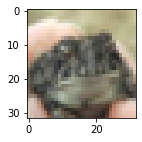

In [8]:
plt.figure(figsize=(2,2))
plt.imshow(x_train[25])

In [0]:
sort_order_train = y_train.argsort(axis=0)
sort_order_test = y_test.argsort(axis=0)

In [0]:
y_train = y_train[sort_order_train] #sorting by the labels and then choosing one
x_train = x_train[sort_order_train]

y_test = y_test[sort_order_test]
x_test = x_test[sort_order_test]

In [0]:
y_train = y_train.reshape((50000,1))
x_train = x_train.reshape((50000,32,32,3))

y_test = y_test.reshape((10000,1))
x_test = x_test.reshape((10000,32,32,3))

In [0]:
typ = 6 #choosing the label of frog
begin_train_frogs = 0
begin_t_f = False
end_train_frogs = 0

begin_test_frogs = 0
begin_test_f = False
end_test_frogs = 0

for i in range(len(y_train)):
  if y_train[i] == typ:
    if begin_t_f == False:
      begin_t_f = True
      begin_train_frogs = i
    end_train_frogs = i

for i in range(len(y_test)):
  if y_test[i] == typ:
    if begin_test_f == False:
      begin_test_f = True
      begin_test_frogs = i
    end_test_frogs = i

x_test = x_test[begin_test_frogs:end_test_frogs]
x_train = x_train[begin_train_frogs:end_train_frogs]

In [0]:
batch_size = 126
original_dim = 1024*3 # shape of orig. pics
latent_dim = 80 # latent dim: 2D
intermediate_dim = 256 
epochs = 15

In [0]:
class KLDivergenceLayer(Layer):

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs


In [15]:

x = Input(shape=(original_dim,))

# hidden layers
h = Dense(intermediate_dim, activation='relu')(x)
h = Dense(intermediate_dim, activation='relu')(h)
h = Dense(intermediate_dim, activation='relu')(h)

# output layers, log of var and mu
z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)



# KL-divergence 
z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])

# normalizing variance
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

# white noise
eps = Input(tensor=K.random_normal(shape=(K.shape(x)[0],
                                          latent_dim)))

# keras Merge rétegek (Multiply, Add) : reparameterization
z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])


# decoder network
decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(intermediate_dim, activation='relu'),
    Dense(intermediate_dim, activation='relu'),
    Dense(intermediate_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
])


# the actual prediction
x_pred = decoder(z)


In [0]:

# log_pθ(x|z)
def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

In [17]:
# the model itself
vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer=Adam(lr=0.0016), loss=nll)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
x_train = x_train.reshape(-1, original_dim) / 255. #preparing the data
x_test = x_test.reshape(-1, original_dim) / 255.

In [19]:
x_train.shape

(4999, 3072)

In [20]:
vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=150,
        batch_size=batch_size,
        validation_data=(x_test, x_test)) #training




Train on 4999 samples, validate on 999 samples
Epoch 1/150





4999/4999 [==============================] - 6s 1ms/step - loss: 2046.5087 - val_loss: 1989.5056
Epoch 2/150
4999/4999 [==============================] - 1s 136us/step - loss: 1983.4679 - val_loss: 1981.7036
Epoch 3/150
4999/4999 [==============================] - 1s 138us/step - loss: 1977.5390 - val_loss: 1970.2047
Epoch 4/150
4999/4999 [==============================] - 1s 138us/step - loss: 1966.4817 - val_loss: 1956.7671
Epoch 5/150
4999/4999 [==============================] - 1s 133us/step - loss: 1956.0245 - val_loss: 1950.0556
Epoch 6/150
4999/4999 [==============================] - 1s 132us/step - loss: 1947.1417 - val_loss: 1942.6071
Epoch 7/150
4999/4999 [==============================] - 1s 132us/step - loss: 1943.5804 - val_loss: 1935.5050
Epoch 8/150
4999/4999 [==============================] - 1s 130us/step - loss: 1932.9590 - val_loss: 1929.6313
Epoch 9/150
4999/4999 [==============================] - 1s

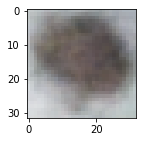

In [26]:
z_sample = norm.ppf(np.random.rand(1,latent_dim)) #generating a picture
generated_digit = decoder.predict(z_sample)
plt.figure(figsize=(2,2))
plt.imshow(generated_digit.reshape(32,32,3))